<a href="https://colab.research.google.com/github/MangoHaha/SentimentAnalysis/blob/investigate_new_Arch/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## General information

In this kernel I'll work with data from Movie Review Sentiment Analysis Playground Competition.

This dataset is interesting for NLP researching. Sentences from original dataset were split in separate phrases and each of them has a sentiment label. Also a lot of phrases are really short which makes classifying them quite challenging. Let's try!

In [3]:
!pip install lightgbm wordcloud

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TweetTokenizer
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
pd.set_option('max_colwidth',400)
from google.colab import drive
import nltk
nltk.download('stopwords')
from google.colab import files


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!ls "/content/drive/My Drive/DeepLearning"

Andrew_best_model.csv	crawl-300d-2M.vec	   train.tsv
Andrew_best_model.hdf5	glove.twitter.27B.25d.txt  well_trained_model.hdf5
best_model.hdf5		sampleSubmission.csv
blend.csv		test.tsv


In [0]:

train = pd.read_csv('/content/drive/My Drive/DeepLearning/train.tsv', sep="\t")
test = pd.read_csv('/content/drive/My Drive/DeepLearning/test.tsv', sep="\t")
sub = pd.read_csv('/content/drive/My Drive/DeepLearning/sampleSubmission.csv', sep=",")
y = train['Sentiment']

In [0]:
train.head(10)

In [0]:
train.loc[train.SentenceId == 2]

In [0]:
print('Average count of phrases per sentence in train is {0:.0f}.'.format(train.groupby('SentenceId')['Phrase'].count().mean()))
print('Average count of phrases per sentence in test is {0:.0f}.'.format(test.groupby('SentenceId')['Phrase'].count().mean()))

In [10]:
print('Number of phrases in train: {}. Number of sentences in train: {}.'.format(train.shape[0], len(train.SentenceId.unique())))
print('Number of phrases in test: {}. Number of sentences in test: {}.'.format(test.shape[0], len(test.SentenceId.unique())))

Number of phrases in train: 156060. Number of sentences in train: 8529.
Number of phrases in test: 66292. Number of sentences in test: 3310.


In [11]:
print('Average word length of phrases in train is {0:.0f}.'.format(np.mean(train['Phrase'].apply(lambda x: len(x.split())))))
print('Average word length of phrases in test is {0:.0f}.'.format(np.mean(test['Phrase'].apply(lambda x: len(x.split())))))

Average word length of phrases in train is 7.
Average word length of phrases in test is 7.


We can see than sentences were split in 18-20 phrases at average and a lot of phrases contain each other. Sometimes one word or even one punctuation mark influences the sentiment

Let's see for example most common trigrams for positive phrases

The results show the main problem with this dataset: there are to many common words due to sentenced splitted in phrases. As a result stopwords shouldn't be removed from text.

### Thoughts on feature processing and engineering

So, we have only phrases as data. And a phrase can contain a single word. And one punctuation mark can cause phrase to receive a different sentiment. Also assigned sentiments can be strange. This means several things:
- using stopwords can be a bad idea, especially when phrases contain one single stopword;
- puntuation could be important, so it should be used;
- ngrams are necessary to get the most info from data;
- using features like word count or sentence length won't be useful;

## Deep learning
And now let's try DL. DL should work better for text classification with multiple layers. I use an architecture similar to those which were used in toxic competition.

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

Using TensorFlow backend.


In [0]:
tk = Tokenizer(lower = True, filters='')
full_text = list(train['Phrase'].values) + list(test['Phrase'].values)
tk.fit_on_texts(full_text)
train_tokenized = tk.texts_to_sequences(train['Phrase'])
test_tokenized = tk.texts_to_sequences(test['Phrase'])

In [0]:
max_len = 50
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

In [0]:
embedding_path = "/content/drive/My Drive/DeepLearning/crawl-300d-2M.vec"
#embedding_path = "/content/drive/My Drive/DeepLearning/glove.twitter.27B.25d.txt"
#embed_size = 25
embed_size = 300
max_features = 30000

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [13]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y.values.reshape(-1, 1))
ohe.fit(train["Sentiment"].values.reshape(-1, 1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

K folds Validation

In [0]:
NUM_FOLDS = 5
train["fold_id"] = train["SentenceId"].apply(lambda x: x%NUM_FOLDS)


An attempt at ensemble:

In [0]:
def build_model1(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    #file_path = "/content/drive/My Drive/DeepLearning/best_model.hdf5"
    #check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
    #                              save_best_only = True, mode = "min")
    #early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(19479, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)
    
    
    x_conv3 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x_conv3)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv3)
    
    x_conv4 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool2_lstm = GlobalAveragePooling1D()(x_conv4)
    max_pool2_lstm = GlobalMaxPooling1D()(x_conv4)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool2_lstm, max_pool2_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(5, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    #history = model.fit(X_train, y_ohe, batch_size = 128, epochs = 1, validation_split=0.1, 
    #                    verbose = 1, callbacks = [check_point, early_stop])
    #model = load_model(file_path)
    return model

In [15]:
trained_model1 = build_model1(lr = 1e-3, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.3, conv_size=32)

Train on 140454 samples, validate on 15606 samples
Epoch 1/1
140454/140454 [==============================] - 79s 562us/step - loss: 0.3656 - acc: 0.8371 - val_loss: 0.3208 - val_acc: 0.8507

Epoch 00001: val_loss improved from inf to 0.32080, saving model to /content/drive/My Drive/DeepLearning/best_model.hdf5


In [0]:
test_preds = np.zeros((test.shape[0], 5))
file_path = "/content/drive/My Drive/DeepLearning/best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")

for i in range(NUM_FOLDS):
    print("FOLD", i+1)
    
    print("Splitting the data into train and validation...")
    train_seq, val_seq = X_train[train["fold_id"] != i], X_train[train["fold_id"] == i]
    y_train = ohe.transform(train[train["fold_id"] != i]["Sentiment"].values.reshape(-1, 1))
    y_val = ohe.transform(train[train["fold_id"] == i]["Sentiment"].values.reshape(-1, 1))
    
    print("Building the model...")
    model = build_model1(lr = 1e-3, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.3, conv_size=32)
        
    print("Training the model...")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 2)

    model.fit(train_seq, y_train, validation_data = (val_seq, y_val), batch_size = 128, epochs = 15, 
                        verbose = 15, callbacks = [check_point, early_stop])    
    print("Predicting...")
    test_preds += model.predict([X_test], batch_size=1024, verbose=1)
    print()
model = load_model(file_path)    
test_preds /= NUM_FOLDS

FOLD 1
Splitting the data into train and validation...
Building the model...
Training the model...
Train on 125230 samples, validate on 30830 samples
Epoch 1/15

Epoch 00001: val_loss improved from inf to 0.31006, saving model to /content/drive/My Drive/DeepLearning/best_model.hdf5
Epoch 2/15

Epoch 00002: val_loss improved from 0.31006 to 0.30595, saving model to /content/drive/My Drive/DeepLearning/best_model.hdf5
Epoch 3/15

Epoch 00003: val_loss improved from 0.30595 to 0.30128, saving model to /content/drive/My Drive/DeepLearning/best_model.hdf5
Epoch 4/15

Epoch 00004: val_loss improved from 0.30128 to 0.29594, saving model to /content/drive/My Drive/DeepLearning/best_model.hdf5
Epoch 5/15

Epoch 00005: val_loss did not improve from 0.29594
Epoch 6/15

Epoch 00006: val_loss improved from 0.29594 to 0.29125, saving model to /content/drive/My Drive/DeepLearning/best_model.hdf5
Epoch 7/15

Epoch 00007: val_loss improved from 0.29125 to 0.29070, saving model to /content/drive/My Driv

In [0]:
pred = trained_model1.predict(X_test, batch_size = 1024, verbose = 1)
sub = pd.read_csv('/content/drive/My Drive/DeepLearning/sampleSubmission.csv', sep=",")
predictions = np.round(np.argmax(pred, axis=1)).astype(int)
sub['Sentiment'] = predictions
print(sub['Sentiment'])
sub.to_csv("/content/drive/My Drive/DeepLearning/blend.csv", index=False)

Print the Arch of trained model

In [16]:
trained_model1.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      5843700     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 50, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 128)      140544      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


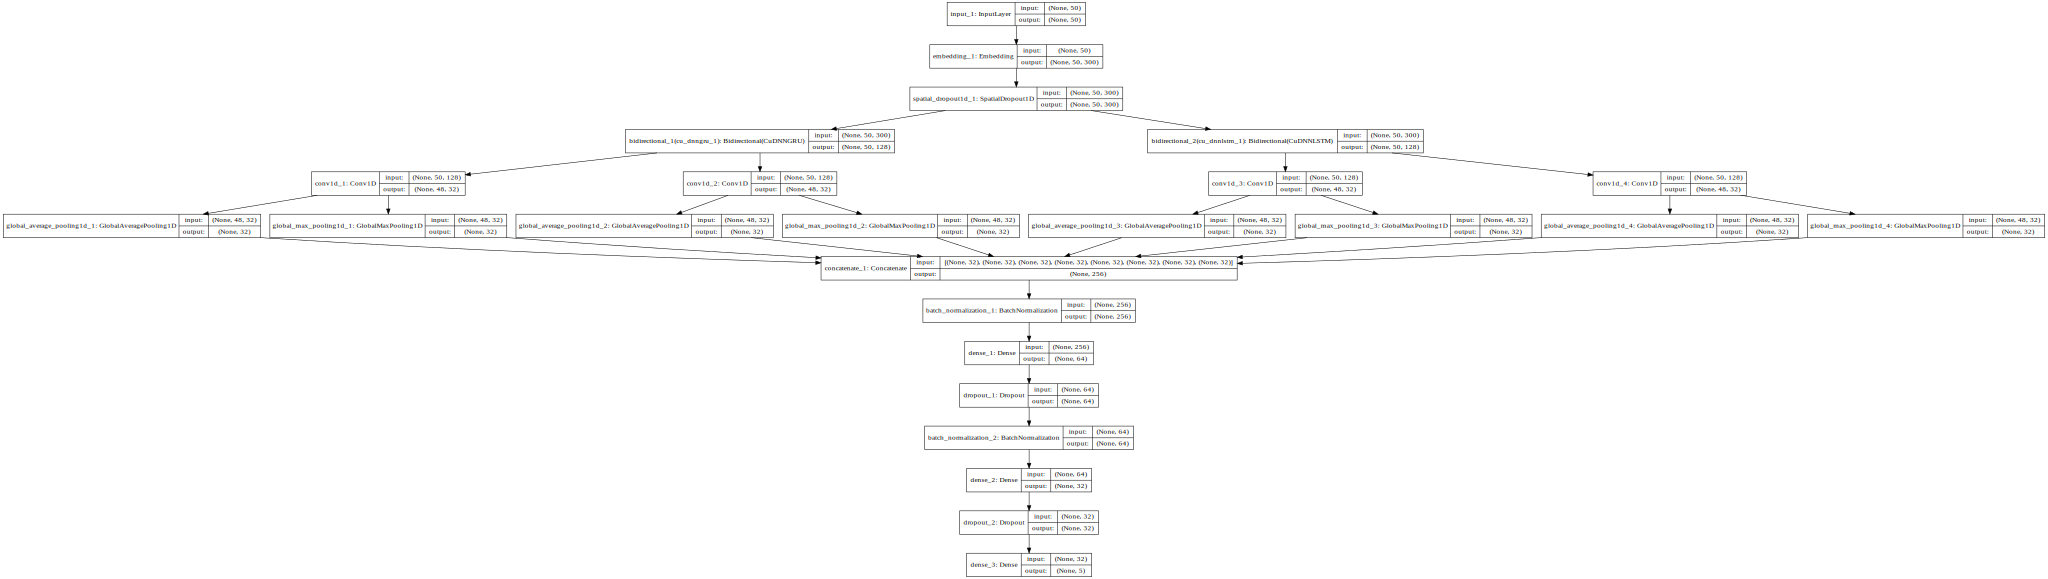

In [17]:
!pip install pydot && apt-get install graphviz

import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(trained_model1,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))